# Question n°1

In [ ]:
#We generate from an alpha distribution with jax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from typing import Sequence, Tuple

In [4]:


def simulation_alpha_stable_mc(alpha: float, beta: float, gamma: float, delta: float, n: int, key):
    """
    Generate n samples from an alpha-stable distribution with parameters alpha, beta, gamma, delta 
    using the Chambers–Mallows–Stuck method.

    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
        key (jax.random.PRNGKey): JAX random key.
        
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.

    example:
        key = jax.random.PRNGKey(0)
        alpha = 1.5
        beta = 0.5
        gamma = 1.0
        delta = 0.0
        n = 10000
        samples = simulation_alpha_stable(alpha, beta, gamma, delta, n, key)

    """
    # Split the key to get independent streams for generating different random variables.
    key_u, key_w = jax.random.split(key)

    half_pi = jnp.pi / 2

    # Generate the required random variables.
    w = jax.random.exponential(key_w, shape=(n,))
    u = jax.random.uniform(key_u, minval=-half_pi, maxval=half_pi, shape=(n,))

    epsi = 1e-6  # Tolerance for comparing alpha with 1

    def branch_alpha_eq_1():
        # Formula for alpha == 1
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        # Parameters used for the Chambers–Mallows–Stuck formula (alpha != 1)
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1 / alpha)) * (
            (jnp.cos(u - alpha * (u + B)))/w
        ) ** ((1 - alpha) / alpha)

    # Choose the appropriate branch based on alpha.
    y = jax.lax.cond(jnp.abs(alpha - 1) < epsi, branch_alpha_eq_1, branch_alpha_neq_1)

    return gamma * y + delta


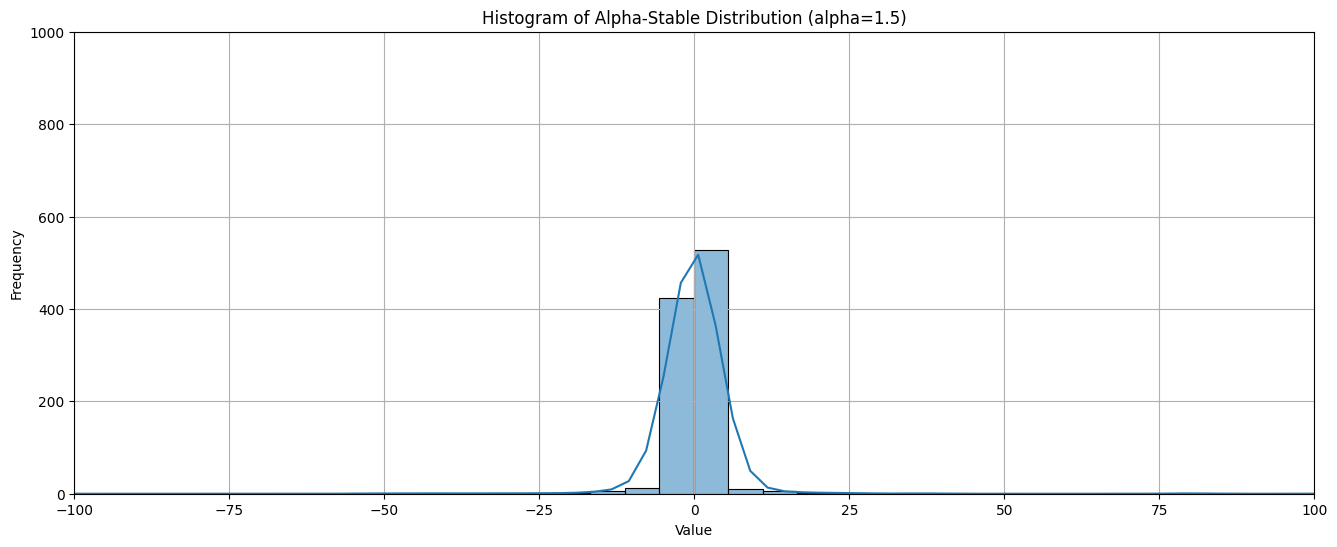

In [3]:
y = simulation_alpha_stable_mc(1, 0, 0.5, 0, 1000, jax.random.PRNGKey(2))
# Plotting the histogram
plt.figure(figsize=(16, 6))
sns.histplot(y, bins=100, kde=True)
plt.title('Histogram of Alpha-Stable Distribution (alpha=1.5)')
plt.xlabel('Value')
plt.xlim(-100,100)
plt.ylabel('Frequency')

plt.ylim(0, 1000)
plt.grid()
plt.show()

# Question n°2

To generate n samples from an  alpha-stable, it is needed to sample from an Exp(1) and a Uniform(-pi/2 , pi/2), so this is where using RQMC is usefull. Indeed, instead of sampling from this laws, it is possible to use a Sobol sequence with scrambling.

Once this is done, there are two variables u,v \in [0,1]^2.

To get the u that is required, the following transformation is used : u' = u*pi - pi/2 //
To get the w that is required, the following transformation is used : w = -log(v)  (inverse CDF)

Then with the correct u and w, it is possible to generate the alpha-stable sample following the method from before.

In [6]:
def simulation_alpha_stable_rqmc(alpha: float, beta: float, gamma: float, delta: float, n: int, seed : int = None):
    """
    Generate n samples from an alpha-stable distribution using an RQMC sequence.
    
    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
    
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.
    """
    # 1. Generate a 2D Sobol sequence with scrambling (RQMC)
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate n points in [0,1]^2
    points = sampler.random(n)
    
    # 2. Transform the first coordinate to [-pi/2, pi/2] for u
    half_pi = jnp.pi / 2
    # Note: Convert the numpy array to a jax array if necessary
    u = jnp.array(points[:, 0]) * jnp.pi - half_pi
    
    # 3. Transform the second coordinate via the inverse CDF to get exponential variables
    v = jnp.array(points[:, 1])
    # Avoid issues with logarithm of zero by adding a small epsilon if needed.
    epsilon = 1e-10
    w = -jnp.log(v + epsilon)
    
    # 4. Calculate y using the Chambers–Mallows–Stuck method
    tol = 1e-6  # tolerance for checking if alpha ~ 1
    
    def branch_alpha_eq_1():
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1/alpha)) * (
            (jnp.cos(u - alpha * (u + B))) / w
        ) ** ((1 - alpha) / alpha)
    
    y = jax.lax.cond(jnp.abs(alpha - 1) < tol, branch_alpha_eq_1, branch_alpha_neq_1)
    
    # 5. Apply the scale and location transformation.
    return gamma * y + delta


Standard Monte Carlo estimates of E[cos(Y)]:
Mean: 0.356933, Std. Dev.: 0.009396

RQMC estimates of E[cos(Y)]:
Mean: 0.355984, Std. Dev.: 0.001166


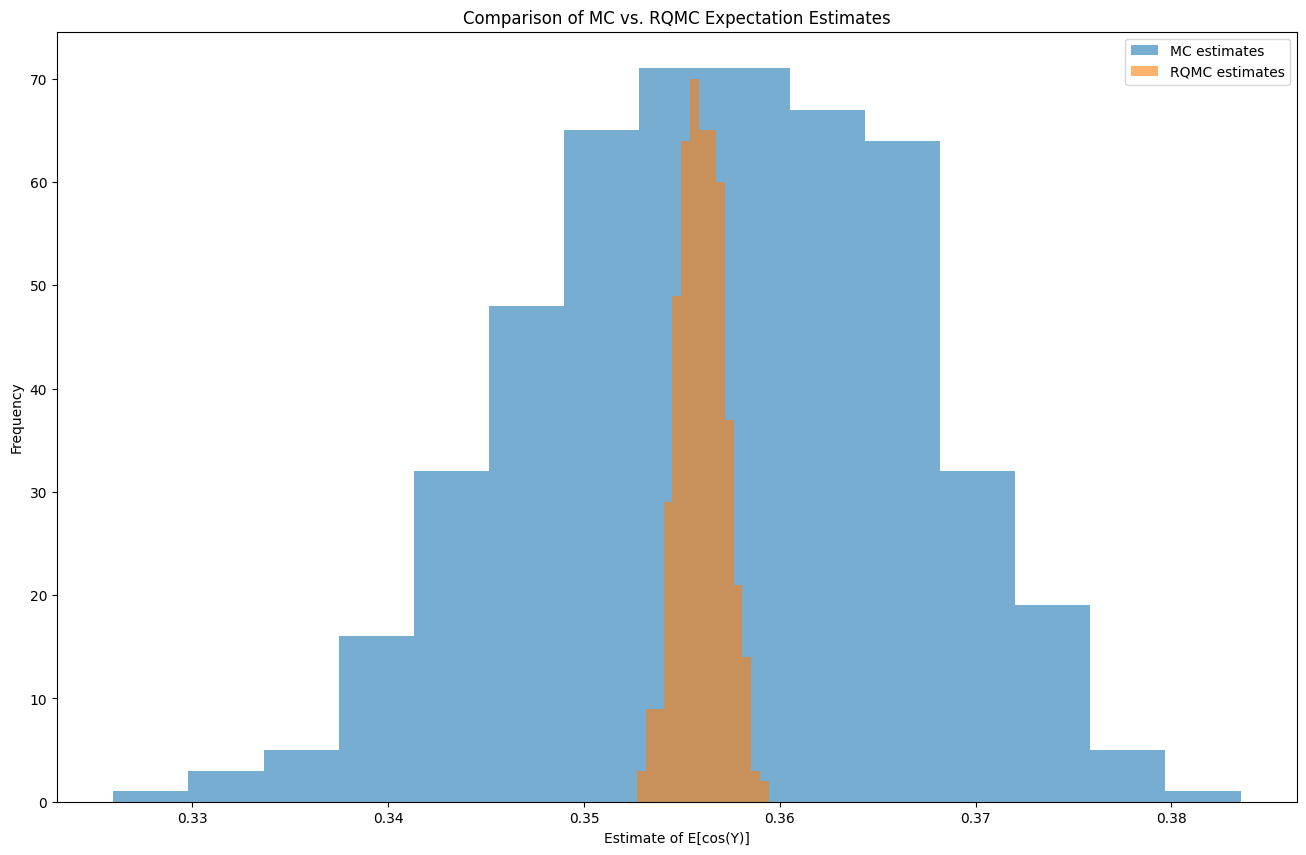

In [5]:
def g(y):
    """
    Bounded function for which to compute the expectation.
    Here, we use g(y) = cos(y).
    """
    return jnp.cos(y)


def estimate_expectation_mc(alpha, beta, gamma, delta, n, reps):
    """ 
    Compute expectation estimates under the alpha-stable distribution using standard MC.
    """
    estimates = []
    for i in range(reps):
        # Use a different seed for each replication.
        key = jax.random.PRNGKey(i)
        samples = simulation_alpha_stable_mc(alpha, beta, gamma, delta, n, key)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)


def estimate_expectation_rqmc(alpha, beta, gamma, delta, n, reps, base_seed=123):
    """ 
    Compute expectation estimates under the alpha-stable distribution using RQMC.
    For each replication, reinitialize the scrambled Sobol generator with a different seed.
    """
    estimates = []
    for i in range(reps):
        seed = base_seed + i  # vary the seed for different scrambling
        samples = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n, seed)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)


# Comparison of MC vs. RQMC estimates


# Parameters for the alpha-stable distribution
alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0
n_samples = 4096  # number of samples per replication (power of 2 for Sobol)
n_replications = 500  # number of replications

# Compute expectation estimates via MC and RQMC
mc_estimates = estimate_expectation_mc(alpha, beta, gamma, delta, n_samples, n_replications) 
rqmc_estimates = estimate_expectation_rqmc(alpha, beta, gamma, delta, n_samples, n_replications)

# Calculate statistics (mean and standard deviation over replications)
mc_mean = float(jnp.mean(mc_estimates))
mc_std  = float(jnp.std(mc_estimates))
rqmc_mean = float(jnp.mean(rqmc_estimates))
rqmc_std  = float(jnp.std(rqmc_estimates))

print("Standard Monte Carlo estimates of E[cos(Y)]:")
print(f"Mean: {mc_mean:.6f}, Std. Dev.: {mc_std:.6f}")
print("\nRQMC estimates of E[cos(Y)]:")
print(f"Mean: {rqmc_mean:.6f}, Std. Dev.: {rqmc_std:.6f}")

# Plotting the distribution of estimates for a visual comparison

plt.figure(figsize=(16,10))
plt.hist(mc_estimates, bins=15, alpha=0.6, label='MC estimates', color='C0')
plt.hist(rqmc_estimates, bins=15, alpha=0.6, label='RQMC estimates', color='C1')
plt.xlabel("Estimate of E[cos(Y)]")
plt.ylabel("Frequency")
plt.title("Comparison of MC vs. RQMC Expectation Estimates")
plt.legend()
plt.show() 

As expected, the variance is way smaller when RQMC is used.

Question n°3

The summary stastistics S1,S2,S3,S4,S5 are first defined.


In [58]:
def S1(x,gamma = 10): #gamma = 10 est une valeur par défaut pour gamma
    """
    Calcule l’estimateur de McCulloch (ou un vecteur de 4 nombres)
    qui correspondent aux estimations de (alpha, beta, gamma, delta) à partir de x.
    """
    # Chercher l'estimateur de McCulloch pour alpha, beta, gamma, delta
    # (voir le papier de McCulloch, 1986)
    q = np.quantile(x, [0.05, 0.25, 0.5, 0.75, 0.95])
    alpha_hat = (q[4]-q[0])/(q[3]-q[1])
    beta_hat = (q[4]+q[0]-2*q[2])/(q[4]-q[0])
    gamma_hat = (q[3]-q[1])/gamma
    delta_hat = np.mean(x)
    return np.array([alpha_hat, beta_hat, gamma_hat, delta_hat])

@jax.jit
def S1_batch(X_batch: jnp.ndarray, *, gamma = 10) -> jnp.ndarray:
    """
    Vectorised McCulloch summary (α̂, β̂, γ̂, δ̂).

    Parameters
    ----------
    X_batch : jnp.ndarray, shape (N_sim, n_obs)
        Each row is a complete simulated sample.
    gamma : float or jnp.ndarray
        Scale parameter γ:
            • scalar → broadcast to each simulation;
            • shape (N_sim,) → one per simulation.

    Returns
    -------
    stats : jnp.ndarray, shape (N_sim, 4)
        Columns = [alpha_hat, beta_hat, gamma_hat, delta_hat].
    """
    # 1. Required quantiles for every simulation

    q_levels = jnp.array([0.05, 0.25, 0.50, 0.75, 0.95])
    # jnp.quantile → shape (len(q), N_sim) → transpose to (N_sim, 5)
    Q = jnp.quantile(X_batch, q_levels, axis=-1, method="linear").T
    q05, q25, q50, q75, q95 = Q.T          # each (N_sim,)

    
    # 2. McCulloch point estimates
    
    denom_a  = q75 - q25 + 1e-12           # avoid div-by-0
    denom_b  = q95 - q05 + 1e-12

    alpha_hat  = (q95 - q05) / denom_a
    beta_hat   = (q95 + q05 - 2.0 * q50) / denom_b

    # Broadcast gamma to (N_sim,)
    gamma_arr  = jnp.asarray(gamma)
    if gamma_arr.ndim == 0:
        gamma_arr = jnp.broadcast_to(gamma_arr, alpha_hat.shape)

    gamma_hat  = denom_a / gamma_arr
    delta_hat  = jnp.mean(X_batch, axis=-1)          # (N_sim,)

    return jnp.stack([alpha_hat, beta_hat, gamma_hat, delta_hat], axis=-1)


In [35]:
def summary_stat_2(X, ksi =  0.25):
    """
    Compute the summary statistics from Zolotarev's transformation.
    """
    # 1)  X -> Z
    Z = np.array([X[3*i-2] - ksi * X[3*i-1] - (1-ksi) * X[3*i] for i in range(1, len(X)//3 + 1)]) 

    # 2) Then we get the summary statistics from Z

    V = np.log(np.abs(Z)
               ) 
    U = np.sign(X)

    S_V = np.var(V
                 )
    S_U = np.var(U)

    eta_hat = np.mean(U)

    teta_hat = np.mean(V)
    
    v_tilde = 6/(np.pi)**2 * S_V - 1.5 * S_U + 1

    v_hat = max(v_tilde, (1+eta_hat)**2 * 0.25)
    delta_hat = np.mean(X)

    return np.array([v_hat , eta_hat, teta_hat, float(delta_hat)])


#Here is the vectorized version of the function above

@jax.jit
def summary_stat_2_batch(X_batch: jnp.ndarray, *, ksi: float = 0.25) -> jnp.ndarray:
   
    n_total = X_batch.shape[-1]
    assert n_total % 3 == 0, "X_i must be dividable by 3."

    
    # 1)  X → Z  
    
    X_reshaped = X_batch.reshape(X_batch.shape[0], n_total // 3, 3)  # (N_sim, n/3, 3)
    Z = (
        X_reshaped[..., 0]
        - ksi * X_reshaped[..., 1]
        - (1.0 - ksi) * X_reshaped[..., 2]
    )                                                                # (N_sim, n/3)

    
    V = jnp.log(jnp.abs(Z) + 1e-12)      # +ε to avoid log(0)
    U = jnp.sign(X_batch)                # (N_sim, n)

    S_V      = jnp.var(V, axis=-1)       # (N_sim,)
    S_U      = jnp.var(U, axis=-1)
    eta_hat  = jnp.mean(U, axis=-1)
    teta_hat = jnp.mean(V, axis=-1)
    delta_hat = jnp.mean(X_batch, axis=-1)

    
    # 3) v_tilde, v_hat
    
    v_tilde = 6.0 / (jnp.pi ** 2) * S_V - 1.5 * S_U + 1.0
    v_hat   = jnp.maximum(v_tilde, 0.25 * (1.0 + eta_hat) ** 2)

    
    return jnp.stack([v_hat, eta_hat, teta_hat, delta_hat], axis=-1)


In [14]:
def empirical_cf(X, t):

    """Empirical characteristic function of X at t"""
    # X is a vector of n samples

    return np.mean(np.exp(1j * t * X))

def u_hat(X, t) :
    """ Return u_hat, which is necessary for Press's of moments"""
    
    sum_cos = np.sum(np.cos(t * X))
    sum_sin = np.sum(np.sin(t * X))
    return np.arctan(sum_sin /sum_cos)  #There is a mistake in the paper that we correct here. (the ratio is inverted in the paper)


def summary_stat_3(X,t1 = 0.2, t2=0.8, t3=0.1,t4=0.4) :
    #We compute the summary statistics from the empirical characteristic function
    # 1) We compute the empirical characteristic function of X for t1, t2, t3 and t4
    phi_t1 = empirical_cf(X, t1)
    phi_t2 = empirical_cf(X, t2)


    # 2) We compute the empirical characteristic function of X for t3 and t4
    log_gam_hat = (np.log(abs(t1))*np.log(-np.log(abs(phi_t2))) - np.log(abs(t2))*np.log(-np.log(abs(phi_t1))) ) / np.log(abs(t1)/abs(t2))

    alpha_hat = np.log((np.log(abs(phi_t1)))/np.log(abs(phi_t2))) / np.log(abs(t1)/abs(t2))

    beta_hat = (u_hat(X, t4)/t4 - u_hat(X, t3)/t3)/((abs(t4)**(alpha_hat-1) - abs(t3)**(alpha_hat-1))*(np.exp(log_gam_hat)**alpha_hat)*np.tan(alpha_hat*np.pi/2))

    delta_hat = (
         abs(t4)**(alpha_hat - 1) * u_hat(X, t3) / t3 - abs(t3)**(alpha_hat - 1) * u_hat(X, t4) / t4
        ) / (abs(t4)**(alpha_hat - 1) - abs(t3)**(alpha_hat - 1))
    

    return np.array([alpha_hat, beta_hat, np.exp(log_gam_hat), delta_hat])


#Here are the vectorized versions of the functions above
@jax.jit
def empirical_cf_batch(X_batch: jnp.ndarray, t: float) -> jnp.ndarray:
    return jnp.mean(jnp.exp(1j * t * X_batch), axis=-1)


@jax.jit
def u_hat_batch(X_batch: jnp.ndarray, t: float) -> jnp.ndarray:
    sum_cos = jnp.sum(jnp.cos(t * X_batch), axis=-1)
    sum_sin = jnp.sum(jnp.sin(t * X_batch), axis=-1)
    return jnp.arctan(sum_sin / sum_cos)          

@jax.jit
def summary_stat_3_batch(
    X_batch: jnp.ndarray,
    *,
    t1: float = 0.2,
    t2: float = 0.8,
    t3: float = 0.1,
    t4: float = 0.4,
) -> jnp.ndarray:
   

    
    phi_t1 = empirical_cf_batch(X_batch, t1)
    phi_t2 = empirical_cf_batch(X_batch, t2)

    
    log_abs_phi_t1 = jnp.log(jnp.abs(phi_t1))
    log_abs_phi_t2 = jnp.log(jnp.abs(phi_t2))

    log_gam_hat = (
        jnp.log(jnp.abs(t1)) * jnp.log(-log_abs_phi_t2)
        - jnp.log(jnp.abs(t2)) * jnp.log(-log_abs_phi_t1)
    ) / jnp.log(jnp.abs(t1 / t2))

    alpha_hat = (log_abs_phi_t1 - log_abs_phi_t2) / jnp.log(jnp.abs(t1 / t2))

    
    u_t3 = u_hat_batch(X_batch, t3)
    u_t4 = u_hat_batch(X_batch, t4)

    
    gamma_hat = jnp.exp(log_gam_hat)                       # shape (N_sim,)

    denom_beta = (
        (jnp.abs(t4) ** (alpha_hat - 1.0) - jnp.abs(t3) ** (alpha_hat - 1.0))
        * gamma_hat**alpha_hat
        * jnp.tan(alpha_hat * jnp.pi / 2.0)
    )
    beta_hat = (u_t4 / t4 - u_t3 / t3) / denom_beta

    denom_delta = jnp.abs(t4) ** (alpha_hat - 1.0) - jnp.abs(t3) ** (alpha_hat - 1.0)
    delta_hat = (
        jnp.abs(t4) ** (alpha_hat - 1.0) * u_t3 / t3
        - jnp.abs(t3) ** (alpha_hat - 1.0) * u_t4 / t4
    ) / denom_delta

    return jnp.stack([alpha_hat, beta_hat, gamma_hat, delta_hat], axis=-1)

In [ ]:
def s4(x):
    """
    Returns concatenated real and imaginary parts.
    """
    #positive grid
    t_pos = np.arange(0.5, 5.1, 0.5)
    #make ±
    t_vals = np.concatenate([t_pos, -t_pos])
    #important to standartise! 
    new_x=(x-np.mean(x))/(np.quantile(x,0.75)-np.quantile(x,0.25))
    #compute φ̂(t) for each t in our grid
    phi = np.array([np.mean(np.exp(1j * t * new_x)) for t in t_vals])
    return np.hstack((phi.real, phi.imag))

@jax.jit
#here is the vectorized version of the function above
def summary_stat_4_batch(X_batch: jnp.ndarray) -> jnp.ndarray:
   
    
    t_pos  = jnp.arange(0.5, 5.1, 0.5)          # (10,)
    t_vals = jnp.concatenate([t_pos, -t_pos])   # (20,)
    k      = t_vals.size                        # 20

    
    mean_X  = jnp.mean(X_batch, axis=-1, keepdims=True)
    q25, q75 = jnp.quantile(X_batch, jnp.array([0.25, 0.75]),
                            axis=-1, keepdims=True, method="linear")
    iqr     = q75 - q25 + 1e-12                 # avoid /0 if IQR=0
    new_x   = (X_batch - mean_X) / iqr          # (N_sim, n_obs)


    exp_term = jnp.exp(1j * new_x[..., None] * t_vals)   # (N_sim, n_obs, k)
    phi      = jnp.mean(exp_term, axis=1)                # (N_sim, k) complexe

    
    stats = jnp.concatenate([phi.real, phi.imag], axis=-1)   # (N_sim, 2k)
    return stats

In [ ]:
def kolmogorov_smirnov_stat(X,Y):
    """
    Compute Kolmogorov Smirnov statistic for two series X and Y.
    """
    n = len(X)
    m = len(Y)
    
    # We combine the two samples and sort them
    # to compute the empirical CDFs
    combined = np.concatenate((X, Y))
    sorted_combined = np.sort(combined)
    
    # We compute the empirical CDFs for X and Y
    # using the sorted combined data
    F_X = np.searchsorted(np.sort(X), sorted_combined, side='right') / n
    F_Y = np.searchsorted(np.sort(Y), sorted_combined, side='right') / m
    
    # Compute the Kolmogorov-Smirnov statistic
    D_n = np.max(np.abs(F_X - F_Y))
    
    return D_n

def summary_stat_5(X, Y):
    """
    Compute the summary statistic S_5 : mean, quantiles, KS(X,Y), .
    """
    # 1. Mean
    mean_X = np.mean(X)
    
    # 2. Quantiles
    quantile_levels = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,
                                 0.8, 0.85, 0.9, 0.95, 0.99])
    quantiles_X = np.quantile(X, quantile_levels)
    
    # 3. Statistic KS
    ks_stat = kolmogorov_smirnov_stat(X, Y)
    
    return np.concatenate(([mean_X], quantiles_X, [ks_stat]))



@jax.jit
def _ks_single(X: jnp.ndarray, Y: jnp.ndarray) -> jnp.ndarray:
    """Compute the two-sample KS statistic for one pair (X, Y)."""
    n, m = X.size, Y.size
    xs, ys = jnp.sort(X), jnp.sort(Y)

    grid = jnp.sort(jnp.concatenate([xs, ys]))      # (n+m,)

    F_X = jnp.searchsorted(xs, grid, side="right") / n
    F_Y = jnp.searchsorted(ys, grid, side="right") / m
    return jnp.max(jnp.abs(F_X - F_Y))              # scalar


_ks_batch = jax.vmap(_ks_single, in_axes=(0, 0))    # vectorise over rows


@jax.jit
def summary_stat_5_batch(
    X_batch: jnp.ndarray,
    Y_batch: jnp.ndarray,
) -> jnp.ndarray:
    """
    Parameters
    ----------
    X_batch, Y_batch : jnp.ndarray, shape (N_sim, n_obs)

    Returns
    -------
    stats : jnp.ndarray, shape (N_sim, 23)
        Columns = [mean | 21 quantiles | KS].
    """
    # 1. Mean of X
    mean_X = jnp.mean(X_batch, axis=-1)                  # (N_sim,)

    # 2. 21 quantiles of X
    q_levels = jnp.asarray(
        [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
         0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75,
         0.80, 0.85, 0.90, 0.95, 0.99],
        dtype=float,
    )
    quantiles_X = jnp.quantile(X_batch, q_levels, axis=-1, method="linear").T

    # 3. KS statistic per simulation
    ks_vals = _ks_batch(X_batch, Y_batch)                # (N_sim,)

    # 4. Concatenate everything
    return jnp.concatenate(
        [mean_X[:, None],              # (N_sim, 1)
         quantiles_X,                  # (N_sim, 21)
         ks_vals[:, None]],            # (N_sim, 1)
        axis=-1
    )

Then all the functions necessary to the ABC algorithms are coded.

In [ ]:
def prior_sample(N):
    """
    Draw N samples (theta) from the prior distribution given in the paper.
    """
    alpha_samples = np.random.uniform(1.1, 2.0, size=N)   # we avoid alpha = 1
    beta_samples  = np.random.uniform(-1.0, 1.0, size=N)
    gamma_samples = np.random.uniform(0.0, 300.0, size=N)
    delta_samples = np.random.uniform(-300, 300, size=N)
    return np.column_stack((alpha_samples, beta_samples, gamma_samples, delta_samples))

def simulate_data(theta, n):
    """
    Draw n samples from the alpha-stable distribution defined by theta, using the rqmc sample.
    """
    alpha, beta, gamma, delta = theta
    
    x = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n) 
    return x

# We vectorise the function above to draw n samples from the alpha-stable distribution defined by theta, using the rqmc sample.

@jax.jit
def _cms_one_param(alpha, beta, gamma, delta, u, w):
    """
    Only one call Chambers–Mallows–Stuck for (u, w) scalars
    and a quadruplet of parameters.
    """
    half_pi = jnp.pi / 2
    tol     = 1e-6

    def alpha_eq_1():
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u)
            - beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def alpha_neq_1():
        S = (1 + beta ** 2 * jnp.tan(half_pi * alpha) ** 2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return (
            S
            * (jnp.sin(alpha * (u + B)) / jnp.cos(u) ** (1 / alpha))
            * (jnp.cos(u - alpha * (u + B)) / w) ** ((1 - alpha) / alpha)
        )

    y = jax.lax.cond(jnp.abs(alpha - 1) < tol, alpha_eq_1, alpha_neq_1)
    return gamma * y + delta


#The function to sample from the alpha-stable distribution using rqmc is vectorised but remains the same as the previous one.
def simulation_alpha_stable_rqmc_batch(
    theta_list: Sequence[Tuple[float, float, float, float]],
    n: int,
    *,
    seed: int | None = None,
) -> jnp.ndarray:
    """
    Sample, from each quadruplet of parameters (α, β, γ, δ) given,
    n alpha-stable values via the same (scrambled) draw of Sobol sequences.

    Parameters
    ----------
    theta_list : list/array-like of shape (N_sim, 4)
        List [(α₁,β₁,γ₁,δ₁), …] of parameters.
    n : int
        Number of samples per simulation.
    seed : int, optional
        Seed for the Sobol scrambling (reproducibility).
    
    Returns
    -------
    samples : jnp.ndarray, shape (N_sim, n)
        Simulated samples. `samples[i]` corresponds to the parameters `theta_list[i]`.
    """
    theta_arr = jnp.asarray(theta_list, dtype=float)
    N_sim     = theta_arr.shape[0]

    # 1. Sobol 2D for each simulation (θ_i) 
    sampler = qmc.Sobol(d=2, scramble=True, seed=seed)
    #   We generate N_sim * n points in [0,1]^2
    sobol_points = sampler.random(N_sim * n)

    # 2. Conversion to (u, w)
    half_pi = jnp.pi / 2
    u_all = jnp.asarray(sobol_points[:, 0]) * jnp.pi - half_pi   # in (-π/2, π/2)
    v_all = jnp.asarray(sobol_points[:, 1])
    epsilon = 1e-10
    w_all = -jnp.log(v_all + epsilon)

    # 3. Reorganisation (N_sim, n)
    u_all = u_all.reshape(N_sim, n)
    w_all = w_all.reshape(N_sim, n)

    # 4. Vectorisation CMS on  dimension n then N_sim 
    
    @jax.vmap                         # map on simulations (θ_i)
    def _simulate_one_param(theta_row, u_row, w_row):
        alpha, beta, gamma, delta = theta_row

        return jax.vmap(
            lambda u, w: _cms_one_param(alpha, beta, gamma, delta, u, w)
        )(u_row, w_row)

    samples = _simulate_one_param(theta_arr, u_all, w_all)
    return samples


In [ ]:
def prior_pdf(theta):
    alpha, beta, gamma, delta = theta

    if 1.1 <= alpha <= 2.0 and -1.0 <= beta <= 1.0 and 0.0 <= gamma <= 300.0 and -300 <= delta <= 300:
        return 1/((2-1.1)*(1+1)*300*600)  # Uniform prior density
    else:
        return 0.0
    
# Perturbation kernel (normal) 
def perturb(theta, cov_matrix):
    return np.random.multivariate_normal(theta, cov_matrix)


def multivariate_normal_pdf(x, mean, cov):
    k = len(mean)
    diff = x - mean
    return np.exp(-0.5 * diff.T @ np.linalg.inv(cov) @ diff) / \
           (np.sqrt((2 * np.pi) ** k * np.linalg.det(cov)))

def kernel_pdf(theta_new, thetas, cov_matrix, weights):
    total = 0
    for i in range(len(thetas)):
        total += weights[i] * multivariate_normal_pdf(theta_new, thetas[i], cov_matrix)
    return total

In [18]:
@jax.jit
def distance_function(S_sim, S_obs):
    diff = S_sim - S_obs
    return jnp.einsum('...i,...i->...', diff, diff)   #Returns the squared distance for computational efficiency in smc_prc_abc


#The function is vectorized to compute the distance for each row of S_sim_batch
@jax.jit
def distance_batch(S_sim_batch: jnp.ndarray, S_obs: jnp.ndarray) -> jnp.ndarray:
    """
    Renvoie la distance euclidienne ||S_sim - S_obs||₂ pour chaque ligne de S_sim_batch.
    S_sim_batch : shape (B, d)   ;   S_obs : shape (d,)
    """
    diff = S_sim_batch - S_obs          # broadcasting (B, d)
    return jnp.sqrt(jnp.sum(diff ** 2, axis=-1))  # (B,)

In [ ]:
#Define the function to compute the distance between the summary statistics of the simulated data and the observed data (necessary for the SMC PRC ABC algorithm)
def estimate_sigma_hat(
    theta_ref,            # θ⋆ (1-d array, dim d)
    simulate_data,        # simulate_data(θ, m) → (m,)     
    summary_statistic,    # S(x) → (k,)
    m,                    # (len(x_obs))
    P   = 1000,           # number of simulations
    ridge = 1e-8          # regularisation term to avoid singularity
):
    """
    Estimate Σ̂ = Cov[S(x)] by Monte-Carlo around theta_ref.

    Returns
    -------
    cov_hat : ndarray (k,k)
    """
    stats = np.empty((P, 0))   # we define it correctly below

    for p in range(P):
        x_sim = simulate_data(theta_ref, m)           # (m,)
        Sx    = summary_statistic(x_sim)              # (k,)

        
        if stats.shape[1] == 0:
            k      = len(Sx)
            stats  = np.empty((P, k))
        stats[p] = Sx


    # covariance matrix (rowar=False → stats are in rows)
    cov_hat = np.cov(stats, rowvar=False)

    # regularisation
    cov_hat += ridge * np.eye(cov_hat.shape[0])

    return cov_hat

In [12]:
# kernel on summary statistics

def kernel_stats(S_obs, S_sim, eps, Sigma_hat):
    """ϕ_k(S_obs ; S_sim, eps² Σ̂)."""
    k        = len(S_obs)
    cov_eps  = (eps**2) * Sigma_hat
    diff     = S_obs - S_sim
    norm_cst = np.sqrt((2*np.pi)**k * np.linalg.det(cov_eps))
    expo     = -0.5 * diff @ np.linalg.inv(cov_eps) @ diff
    return np.exp(expo) / norm_cst
   

# Density of mutation M_t(θ)

def kernel_pdf(theta_new, thetas, Lambda, weights):
    inv_L   = np.linalg.inv(Lambda)
    det_L   = np.linalg.det(Lambda)
    k       = thetas.shape[1]
    norm    = 1.0 / np.sqrt((2*np.pi)**k * det_L)

    diff    = theta_new - thetas           
    maha    = np.einsum('ij,jk,ik->i', diff, inv_L, diff)   
    mvn     = norm * np.exp(-0.5 * maha)                   
    return np.dot(weights, mvn)                            # scalaire



# Resampling multinomial
def multinomial_resample(particles, weights, N_out):
    M   = len(particles)
    idx = np.random.choice(M, size=N_out, p=weights/weights.sum())
    return particles[idx], np.full(N_out, 1.0/N_out)

In [ ]:

#Necessary to the MCMC ABC algorithm
def log_uniform_pdf(point,param,lb,up,p):
    #calculate pdf at point "point" at parameters "param"
    a_low  = max(lb, param - p) 
    a_high = min(up, param + p)

    if a_low<point<a_high:
        return -np.log(a_high-a_low)#pdf uniform
     
    return -np.inf#force reject if out of the interval

def log_g(teta_point,teta_parameter):
    """ 
    evaluate pdf at point "point" | parameter theta
    """

    alpha_point, beta_point, gamma_point, delta_point=teta_point
    alpha_parameter, beta_parameter, gamma_parameter, delta_parameter=teta_parameter
    
    #evaluate first uniforms
    log_pdf_alpha=log_uniform_pdf(alpha_point,alpha_parameter,1.1,2,p=0.1)
    log_pdf_beta=log_uniform_pdf(beta_point,beta_parameter,-1,1,p=0.2)
    log_pdf_gamma=log_uniform_pdf(gamma_point,gamma_parameter,0,300,p=60)
    log_pdf_delta=log_uniform_pdf(delta_point,delta_parameter,-300,300,p=120)
    #joint density=prod of marginal densities=sum of log of marginal densities, just sum them up 
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta


def log_prior(teta):
    #calculate joint density of theta
    alpha_input, beta_input, gamma_input, delta_input=teta

    if not (1.1<alpha_input<2) or not (-1<beta_input<1) or  not (0<gamma_input<300) or  not (-300<delta_input<300):
        return -np.inf#force rejection
    #marginal densities:


    #in log 
    log_pdf_alpha=-np.log(2-1.1)
    log_pdf_beta=-np.log(2)

    log_pdf_gamma=-np.log(300)
    log_pdf_delta=-np.log(600)



    #joint density=prod of marginal densities=sum of log of marginal densities
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta
    # return log_pdf_alpha*log_pdf_beta*log_pdf_gamma*log_pdf_delta

def g(teta):
    """
     
        α∼U[1.1,2],β∼U[−1,1],γ∼U[0,300]andδ∼U[−300,300]
  
    """

    alpha_input, beta_input, gamma_input, delta_input=teta

    a_low  = max(1.1, alpha_input - 0.1) 
    a_high = min(2.0, alpha_input + 0.1)
    alpha = np.random.uniform(a_low, a_high)  

    b_low  = max(-1.0, beta_input - 0.2)
    b_high = min( 1.0, beta_input + 0.2) 
    beta  = np.random.uniform(b_low, b_high)


    gamma = np.random.uniform(max(0.0,      gamma_input-60),
                              min(300.0,    gamma_input+60))

   
    delta = np.random.uniform(max(-300.0,   delta_input-120),
                              min( 300.0,   delta_input+120))


 


    return np.array((alpha, beta, gamma, delta))

def simulate_xi(teta):
    alpha_input, beta_input, gamma_input, delta_input=teta

    x=simulation_alpha_stable_rqmc(alpha_input, beta_input, gamma_input, delta_input,4096  )
    return x


Below this markdown are the 3 ABC algorithm that were used.  

1. ABC Reject : there are two versions the first one that is non-vectorised (our first try) is not usable : it takes way to much even with large epsilon. The second is vectorised but still takes about an hour for small epsilon 

2. MCMC ABC :

3. SMC PRC ABC : Only one **non vectorised** version that sticks to the Appendix A



In [13]:
#First version of the ABC rejection algorithm, non vectorized and non usable (too slow) for large N
def abc_rejection(y_obs,sum_stat, N, n_sim, epsilon):
    """
    y_obs:  observed data (1D array)
    sum_stat : summary statistic function (x -> S(x))
    N: number of draws from the prior to consider
    n_sim: size of the simulated sample for each theta
    epsilon: ABC threshold
    """


    s_obs = sum_stat(y_obs)
    accepted_thetas = []

    while len(accepted_thetas) < N:
        
        thetas = prior_sample(3*N)  #It avoid draw theta_i from the prior each time

       
        for i in tqdm(range(len(thetas))):
            theta_i = thetas[i]
            x_i = simulate_data(theta_i, n_sim)
            s_i = sum_stat(x_i)
            dist = distance_function(s_i, s_obs)**1/2
            if np.log(dist) < np.log(epsilon):
                accepted_thetas.append(theta_i)
            if len(accepted_thetas) >= N:
                break

    return np.array(accepted_thetas[:N])

In [ ]:
  
#  ABC rejection vectorisé
def abc_rejection_vec(
    y_obs: np.ndarray,
    summary_stat_batch,                   # ex. summary_stat_2_batch
    prior_sample,                         # callable (K,) -> (K, dθ)
    sim_rqmc_batch,                       # callable (Θ, n) -> (K, n)
    N: int,
    n_sim: int,
    epsilon: float,
    batch_size: int = 5_000,              # nb de θ tirés à la fois
    tqdm_bar: bool = True,
):
    """
    ABC-Rejection (rejet pur) vectorised.

    Parameters
    ----------
    y_obs            : 1-D observed data (longueur multiple de 3 pour Zolotarev)
    summary_stat_batch : return the summary statistics for a batch of data
    prior_sample     : sample from the prior —  prior_sample(K) -> (K, dθ)
    sim_rqmc_batch   : simulate RQMC for a batch of parameters
    N                : number of accepted theta
    n_sim            : number of simulations for each theta (it has to be a multiple of 3)
    epsilon          : threshold for acceptance
    batch_size       : number of θ drawn at once (default 5000)
    """


    S_obs = summary_stat_batch(jnp.asarray(y_obs)[None, :])[0]

    accepted = []
    pbar = tqdm(total=N, disable=not tqdm_bar, desc="Accepted")

    # 1) While loop for ABC-Rejection
    while len(accepted) < N:
    
        theta_block = prior_sample(batch_size)              # (B, dθ)

        
        X_block = sim_rqmc_batch(theta_block, n_sim)        # (B, n_sim)

        
        S_block = summary_stat_batch(X_block)               # (B, d_stat)

        
        dists = distance_batch(S_block, S_obs)              # (B,)

        
        mask = dists < epsilon
        if mask.any():
            accepted.extend(theta_block[mask].tolist())
            pbar.update(int(mask.sum()))

    pbar.close()
    return np.asarray(accepted[:N])          # shape (N, dθ)

In [47]:
def abc_mcmc(y_obs,N,statistic,epsilon,init):
    #declare our matrix theta where we will store alpha beta delta gama
    theta=np.zeros((N,4))

    #initial good guess
    theta[0,:]=init

    sy=statistic(y_obs)
    counts=0
    pbar = tqdm(range(1, N))
    for i in pbar:
        theta_new=g(theta[i-1,:])
        x_sim=simulate_xi(theta_new)
        sx=statistic(x_sim)
        di=distance_function(sx,sy)**1/2
        # # DS.append(di)
        # print(di)

        if di<epsilon:
            # print("-")
            #if in log
            r=log_prior(theta_new)-log_prior(theta[i-1,:])+log_g(theta[i-1,:],theta_new)-log_g(theta_new,theta[i-1,:])
           
            alpha=min(1,np.exp(r))
            if np.random.rand() < alpha:
                #we accept here 
                # print("_________________________________")
                theta[i,:] = theta_new
                counts=counts+1
                
              
            else:
                #we reject here 
                theta[i,:] = theta[i-1,:]
        else:
            #we reject here 
                theta[i,:] = theta[i-1,:]
        pbar.set_description(f"Accepted: {counts}")
    return theta,counts

In [ ]:
#  SMC-PRC-ABC (Peters et al., 2009)
# Coded as explained in the paper, without modifications, at the cost of no vectorization.
def smc_prc_abc_(
    x_obs, summary_statistics,
    *,
    N             = 1000,
    T             = 6,
    epsilons      = None,
    Lambda        = np.diag([0.25,0.25,1.,1.]),   # covariance of mutation kernel
    Sigma_hat     = None,          # covariance of summary statistics
    prior_sample  = None,
    prior_pdf     = None,
    simulate_data = None,
    random_state  = None, # for reproducibility
):
    """
    Approximate Bayesian Computation by SMC-PRC.

    Returns
    -------
    thetas : ndarray  shape (N, d)
        Particules after the last generation, re-sampled.
    w_out  : ndarray  shape (N,)
        Weights (uniforms) after the last resampling.
    """
    rng = np.random.default_rng(random_state)

    # Default Parameters 
    if epsilons is None:
        epsilons = np.linspace(2.0, 0.2, T)
    epsilons = np.asarray(epsilons, dtype=float)
    if len(epsilons) != T:
        raise ValueError("len(epsilons) has to be T.")
    if Lambda is None:
        raise ValueError("No Lambda was given.")

    S_obs = summary_statistics(x_obs)

    
    # 1) Initialisation   (t = 1)
    thetas, w = [], []
    while len(thetas) < N:
        theta = prior_sample(1)[0]
        x_sim = simulate_data(theta, len(x_obs))
        S_sim = summary_statistics(x_sim)
        w_theta = kernel_stats(S_obs, S_sim, epsilons[0], Sigma_hat)  # π_LF/π
        thetas.append(theta)
        w.append(w_theta)

    thetas = np.asarray(thetas)
    w      = np.asarray(w, dtype=float)
    w     /= w.sum()                                       # normalisation

    # -resampling
    idx     = rng.choice(N, size=N, replace=True, p=w)
    thetas  = thetas[idx]
    w_prev  = np.full(N, 1.0 / N)                          #  uniforms weights

    #  2)  SMC for t = 2 … T
    
    for t in tqdm(range(1, T), desc="SMC-PRC-ABC"):  # # progress bar
        
        eps_t = epsilons[t]

        # 2a)  adaptative threshold c_t 
        pilot_w = []
        while len(pilot_w) < N:                            # N "propositions"
            j      = rng.choice(N, p=w_prev)
            theta0 = thetas[j]
            theta_prop = rng.multivariate_normal(theta0, Lambda)

            if prior_pdf(theta_prop) == 0.0:
                continue

            x_sim = simulate_data(theta_prop, len(x_obs))
            S_sim = summary_statistics(x_sim)
            K_val = kernel_stats(S_obs, S_sim, eps_t, Sigma_hat)
            m_val = kernel_pdf(theta_prop, thetas, Lambda, w_prev)
            if m_val == 0.0:
                continue                                  # avoid ∞

            pilot_w.append(prior_pdf(theta_prop) * K_val / m_val)

        c_t = np.percentile(pilot_w, 90)

        #  2b) Mutation + PRC 
        accepted, acc_w = [], []
        while len(accepted) < N:
            j      = rng.choice(N, p=w_prev)
            theta0 = thetas[j]
            theta_prop = rng.multivariate_normal(theta0, Lambda)

            if prior_pdf(theta_prop) == 0.0:
                continue

            x_sim = simulate_data(theta_prop, len(x_obs))
            S_sim = summary_statistics(x_sim)
            K_val = kernel_stats(S_obs, S_sim, eps_t, Sigma_hat)
            m_val = kernel_pdf(theta_prop, thetas, Lambda, w_prev)
            if m_val == 0.0:
                continue                                  # avoid ∞/0

            W_val = prior_pdf(theta_prop) * K_val / m_val
            rho   = min(1.0, W_val / c_t)

            if rng.random() <= rho:                       # accepted
                w_corr = W_val / rho                      # weight corrected
                if np.isfinite(w_corr) and w_corr > 0.0:
                    accepted.append(theta_prop)
                    acc_w.append(w_corr)

        accepted = np.asarray(accepted)
        acc_w    = np.asarray(acc_w, dtype=float)

        # 2c) Robust normalisation 
        good = np.isfinite(acc_w)
        if not np.all(good):                              # avoid NaN/Inf
            acc_w = np.where(good, acc_w, 0.0)

        tot = acc_w.sum()
        if tot == 0.0:                                    # safeguard
            acc_w[:] = 1.0 / len(acc_w)
        else:
            acc_w /= tot

        # 2d) Resampling 
        idx     = rng.choice(N, size=N, replace=True, p=acc_w)
        thetas  = accepted[idx]
        w_prev  = np.full(N, 1.0 / N)

    
    return thetas, w_prev


Text(0.5, 1.0, 'Histogram of Observed Data')

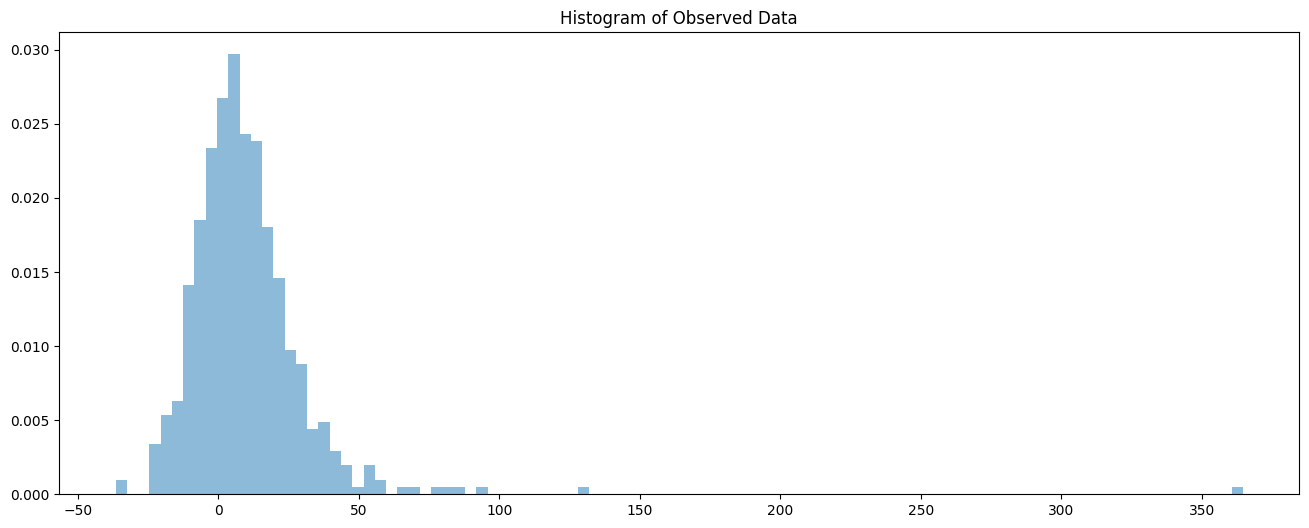

In [ ]:

# 1) Simulation of the observed data given theta from the paper.
theta = (1.7, 0.9, 10, 10)
x_obs = simulate_data(theta, 512) # For the simulation, we use 512 samples, for complexity reasons. But it has to be a power of 2.
plt.figure(figsize=(16, 6))
plt.hist(x_obs, bins=100, density=True, alpha=0.5, label='Observed Data', color='C0')
plt.title('Histogram of Observed Data')


In [71]:
def s5(x):
    return summary_stat_5(x, x_obs)
# We need this function because of the way we defined the summary statistics function.

Below the ABC Rejection is run for each summary statistic 

Running all the cells takes about 40 minutes

In [59]:
accepted_thetass1 = abc_rejection_vec(
    y_obs = x_obs, 
    summary_stat_batch= S1_batch, 
    prior_sample= prior_sample, 
    sim_rqmc_batch= simulation_alpha_stable_rqmc_batch, N=1000, n_sim=512, epsilon=0.78125)

Accepted:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\elyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [194]:
y_obs = x_obs[:300]
accepted_thetas2 = abc_rejection_vec(
    y_obs          = y_obs,             # 1-D array
    summary_stat_batch = summary_stat_2_batch,
    prior_sample   = prior_sample,
    sim_rqmc_batch = simulation_alpha_stable_rqmc_batch,
    N              = 1_000,                  # on veut 1000 θ acceptés
    n_sim          = 300,                    # (multiple de 3)
    epsilon        = 0.78125,                   # seuil ABC
    batch_size     = 10_000,                 # bloc de travail
)

print(accepted_thetas2.shape)   # (1000, dθ)

Acceptés:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\elyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


(1000, 4)


In [ ]:
accepted_thetass3 = abc_rejection_vec(
    y_obs          = x_obs,             # 1-D array
    summary_stat_batch = summary_stat_3_batch,
    prior_sample   = prior_sample,
    sim_rqmc_batch = simulation_alpha_stable_rqmc_batch,
    N              = 1_000,                  # on veut 1000 θ acceptés
    n_sim          = 512,                    # (multiple de 3)
    epsilon        = 0.78125,                   # seuil ABC
    batch_size     = 10_000,                 # bloc de travail
)

Acceptés:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\elyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [34]:
accepted_thetass4 = abc_rejection_vec(
    y_obs          = x_obs,             # 1-D array
    summary_stat_batch = summary_stat_4_batch,
    prior_sample   = prior_sample,
    sim_rqmc_batch = simulation_alpha_stable_rqmc_batch,
    N              = 1_000,                  # on veut 1000 θ acceptés
    n_sim          = 512,                    # (multiple de 3)
    epsilon        = 0.78125,                   # seuil ABC
    batch_size     = 10_000,                 # bloc de travail
)



Accepted: 6698it [00:01, 5815.90it/s]


In [28]:
def make_s5_batch(x_obs):
    """
    Returns a function f(X_batch) that produces the S5 statistics
    using X_batch as sample and the fixed observed sample x_obs as Y.
    """
    # Capture the observed sample as an immutable JAX constant
    x_obs_const = jnp.asarray(x_obs)                       # (n_obs,)

    @jax.jit
    def _s5_batch(X_batch: jnp.ndarray) -> jnp.ndarray:
        """
        X_batch : (N_sim, n_obs)
        """
        # Broadcast x_obs_const to (N_sim, n_obs) without copying
        Y_batch = jnp.broadcast_to(x_obs_const, X_batch.shape)
        return summary_stat_5_batch(X_batch, Y_batch)      # (N_sim, 23)

    return _s5_batch

In [30]:
s5_batch_fn = make_s5_batch(x_obs)

In [38]:
accepted_thetass5 = abc_rejection_vec(
    y_obs          = x_obs,             # 1-D array
    summary_stat_batch = s5_batch_fn,
    prior_sample   = prior_sample,
    sim_rqmc_batch = simulation_alpha_stable_rqmc_batch,
    N              = 1_000,                  # on veut 1000 θ acceptés
    n_sim          = 512,                    # 
    epsilon        = 100,                   # seuil ABC #la dimension étant plus grande, le seuil est plus grand
    batch_size     = 10_000,                 # bloc de travail
)











































































Accepted: 1004it [02:04,  8.04it/s]


Below the ABC MCMC is run for each summary statistic. 



In [43]:
np.random.seed(1234)#just to reproduce same results (aligned with our report)
y_obs=simulation_alpha_stable_rqmc(1.7, 0.9, 10, 10, n=4096, )

In [94]:
#s3-----------------------
np.random.seed(1234)
init=prior_sample(1)[0]#initial guess for theta[0,:]
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s3,counts_accept_s3=abc_mcmc(y_obs,1000,summary_stat_3,epsilon=100,init=init)
print(100*counts_accept_s3/1000,"% accepted for s3")
burn = int(0.2 * len(theta_s3))
theta_posterior_s3= theta_s3[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [  1.27236751   0.24421754 131.3183217  171.21515023]


  0%|          | 0/999 [00:00<?, ?it/s]

52.6 % accepted for s3


In [96]:
#s4-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample(1)[0]
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s4,counts_accept_s4=abc_mcmc(y_obs,1000,s4,epsilon=0.78125,init=init)
print(100*counts_accept_s4/1000,"% accepted for s4")
burn = int(0.2 * len(theta_s4))
theta_posterior_s4= theta_s4[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [  1.27236751   0.24421754 131.3183217  171.21515023]


  0%|          | 0/999 [00:00<?, ?it/s]

86.9 % accepted for s4


In [97]:
#s2-----------------------very long to calculate 
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample(1)[0]
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s4,counts_accept_s4=abc_mcmc(y_obs,1000,summary_stat_2,epsilon=10,init=init)
print(100*counts_accept_s4/1000,"% accepted for s2")
burn = int(0.2 * len(theta_s4))
theta_posterior_s2= theta_s4[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [  1.27236751   0.24421754 131.3183217  171.21515023]


  0%|          | 0/999 [00:00<?, ?it/s]

3.5 % accepted for s2


In [98]:
#s1-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample(1)[0]#initial guess for theta[0,:]
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s1,counts_accept_s1=abc_mcmc(y_obs,1000,S1,1000,init=init)
print(100*counts_accept_s1/1000,"% accepted for s1")
burn = int(0.2 * len(theta_s1))
theta_posterior_s1= theta_s1[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [  1.27236751   0.24421754 131.3183217  171.21515023]


  0%|          | 0/999 [00:00<?, ?it/s]

22.0 % accepted for s1


In [100]:
#s5-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample(1)[0]#initial guess for theta[0,:]
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s1,counts_accept_s1=abc_mcmc(y_obs,1000,s5,699999,init=init) #epsilon=699999 because dimension is bigger
print(100*counts_accept_s1/1000,"% accepted for s5")
burn = int(0.2 * len(theta_s1))
theta_posterior_s5= theta_s1[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [  1.27236751   0.24421754 131.3183217  171.21515023]


  0%|          | 0/999 [00:00<?, ?it/s]

49.0 % accepted for s5


Then the SMC_PRC_ABC is run for each summary statistic.

Attention be aware that the execution is very slow because no optimisation was from done (in order to fit as much as possible to appendix A) and running all the cells takes about 5 hours.

In [ ]:

# The epsilon values for the simulation. We cannot take those from the paper, the computation time would be too long.

eps = [1000,100,50,25,12.5,6.25,3.125,1.5625,0.78125]
T = len(eps)

In [64]:
thetas1, w1 = smc_prc_abc_(
    x_obs,
    summary_statistics=S1,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1.0, 1.0]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, S1, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data,
)

SMC-PRC-ABC:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
## ATTENTION : Running this code will take a long time. (~ 5 hour)
thetas2, w2 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=summary_stat_2,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, summary_stat_2, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)


SMC-PRC-ABC:   0%|          | 0/8 [00:00<?, ?it/s]

In [147]:
thetas3, w3 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=summary_stat_3,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, summary_stat_3, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

SMC-PRC-ABC:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
thetas4, w4 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=s4,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, s4, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

In [ ]:

thetas5, w5 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=s5,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, s5, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

Then a function is coded to see the theta obtained from each ABC algorithms

In [49]:
def plot_theta(particles,id):
    df = pd.DataFrame(particles, columns=["alpha", "beta", "gamma", "delta"])

    df.hist(bins=50, figsize=(10, 6))
    plt.suptitle("Marginal posterior distributions S{}".format(id) )
    plt.show()

    mean = np.mean(particles, axis=0)
    ci95 = np.percentile(particles, [2.5, 97.5], axis=0)

    for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
        print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")

Here are the plots of the paramaters obtained

The thetas from SMC-PRC-ABC algorithm

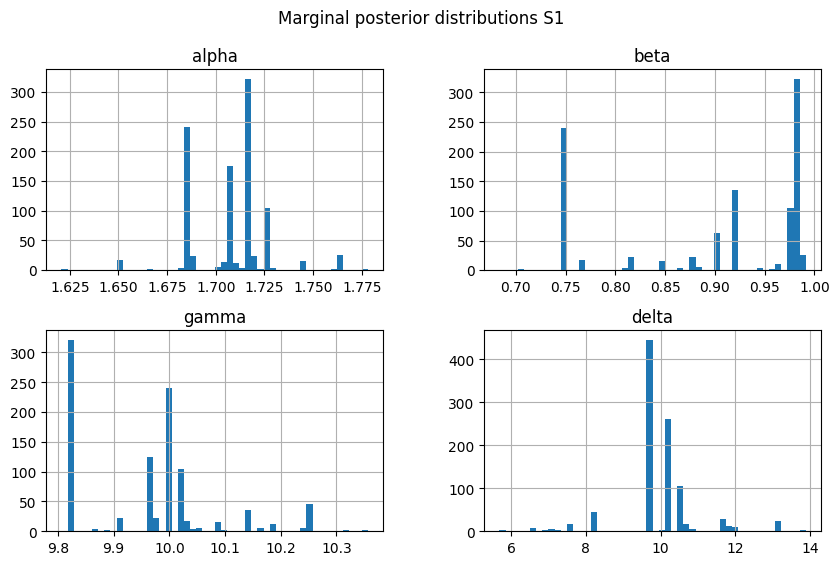

alpha  mean = 1.708,  95% CI = [1.681, 1.763]
beta   mean = 0.900,  95% CI = [0.751, 0.985]
gamma  mean = 9.965,  95% CI = [9.828, 10.250]
delta  mean = 9.978,  95% CI = [7.547, 13.068]


In [65]:
plot_theta(thetas1,1)

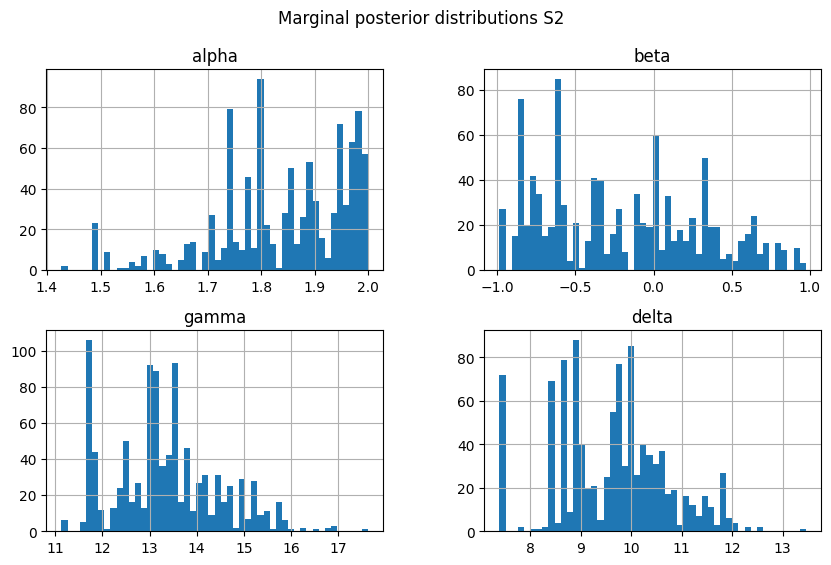

alpha  mean = 1.839,  95% CI = [1.510, 1.992]
beta   mean = -0.201,  95% CI = [-0.985, 0.813]
gamma  mean = 13.348,  95% CI = [11.656, 15.731]
delta  mean = 9.610,  95% CI = [7.393, 11.812]


In [ ]:
plot_theta(thetas2,2)
plot_theta(thetas3,3)
plot_theta(thetas4,4)
plot_theta(thetas5,5)

The thetas from MCMC ABC

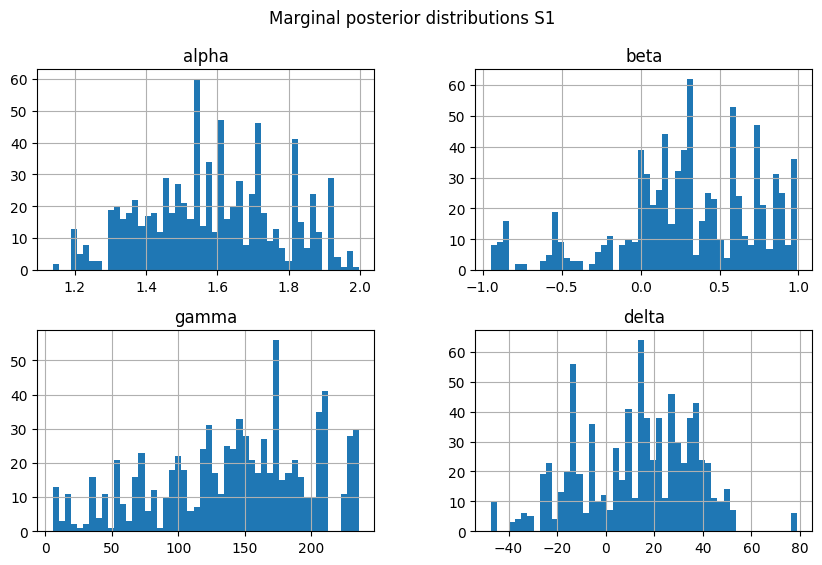

alpha  mean = 1.588,  95% CI = [1.236, 1.927]
beta   mean = 0.292,  95% CI = [-0.870, 0.978]
gamma  mean = 142.163,  95% CI = [17.968, 235.972]
delta  mean = 12.689,  95% CI = [-33.114, 49.728]


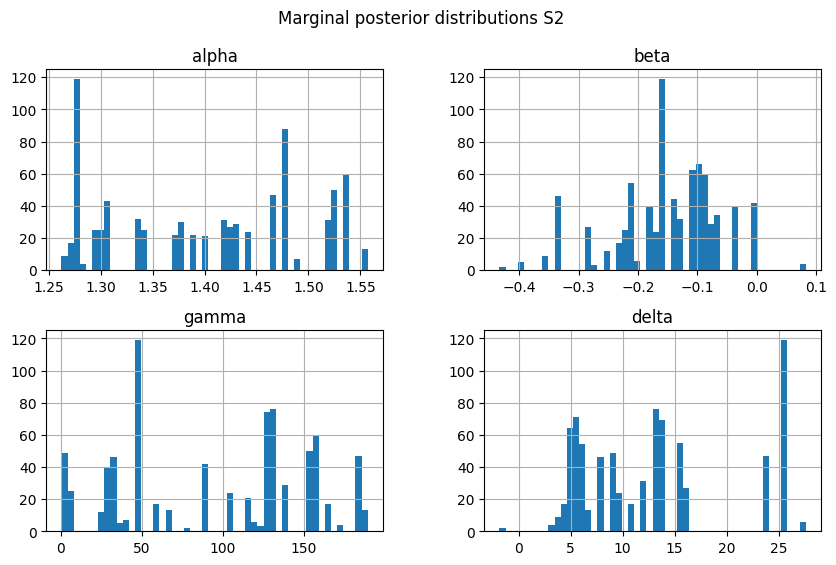

alpha  mean = 1.402,  95% CI = [1.273, 1.535]
beta   mean = -0.149,  95% CI = [-0.332, -0.004]
gamma  mean = 94.991,  95% CI = [0.430, 185.470]
delta  mean = 12.989,  95% CI = [4.593, 25.795]


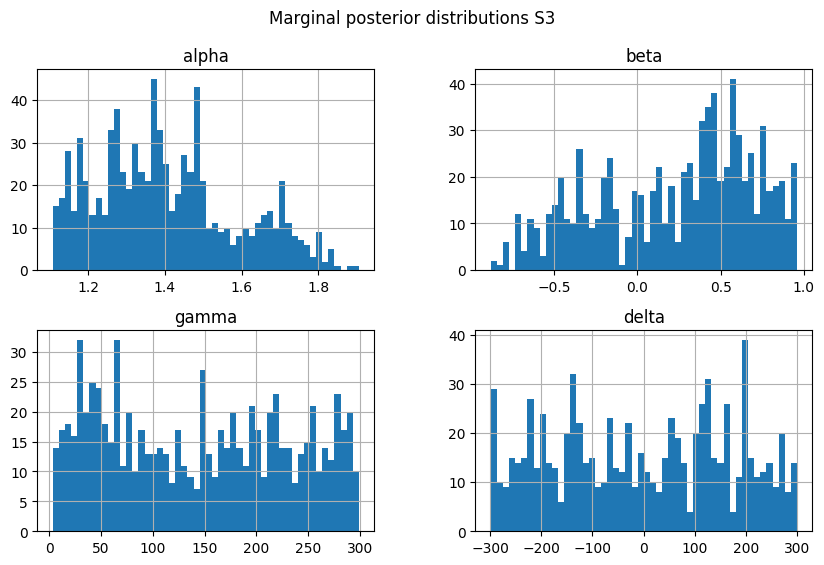

alpha  mean = 1.404,  95% CI = [1.132, 1.783]
beta   mean = 0.231,  95% CI = [-0.696, 0.927]
gamma  mean = 144.250,  95% CI = [11.825, 289.340]
delta  mean = -4.215,  95% CI = [-292.215, 280.309]


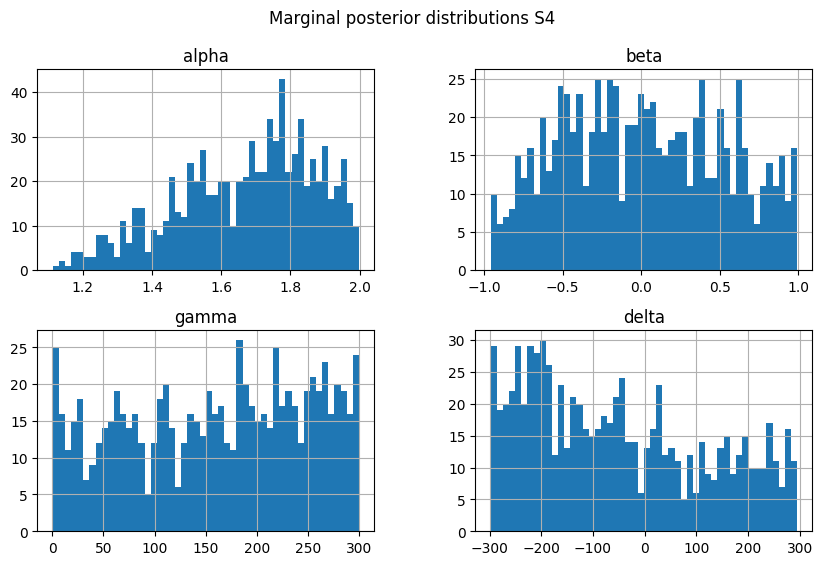

alpha  mean = 1.670,  95% CI = [1.239, 1.971]
beta   mean = 0.014,  95% CI = [-0.864, 0.925]
gamma  mean = 159.824,  95% CI = [5.585, 295.022]
delta  mean = -50.814,  95% CI = [-289.153, 278.405]


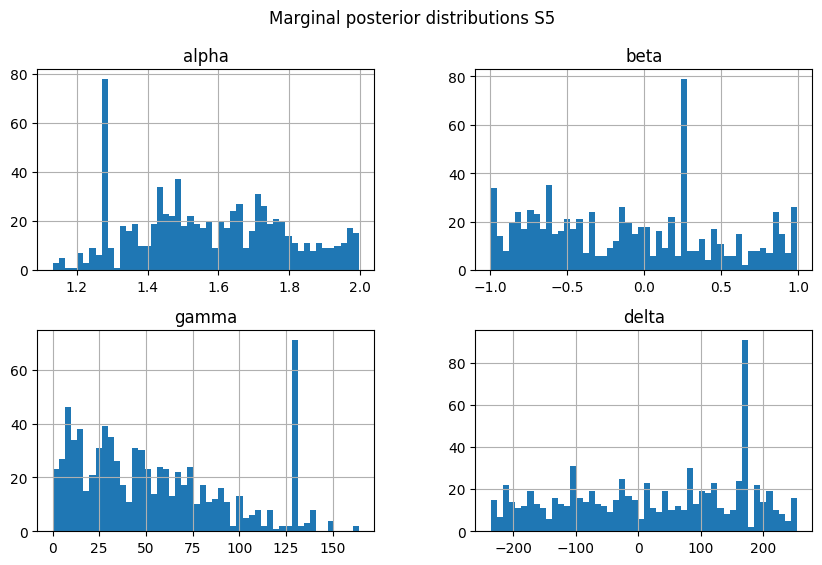

alpha  mean = 1.571,  95% CI = [1.239, 1.973]
beta   mean = -0.102,  95% CI = [-0.970, 0.961]
gamma  mean = 54.938,  95% CI = [3.132, 131.318]
delta  mean = 22.067,  95% CI = [-218.904, 236.428]


In [101]:
plot_theta(theta_posterior_s1,1)
plot_theta(theta_posterior_s2,2)
plot_theta(theta_posterior_s3,3)
plot_theta(theta_posterior_s4,4)
plot_theta(theta_posterior_s5,5)

The thetas from ABC Reject Algorithm

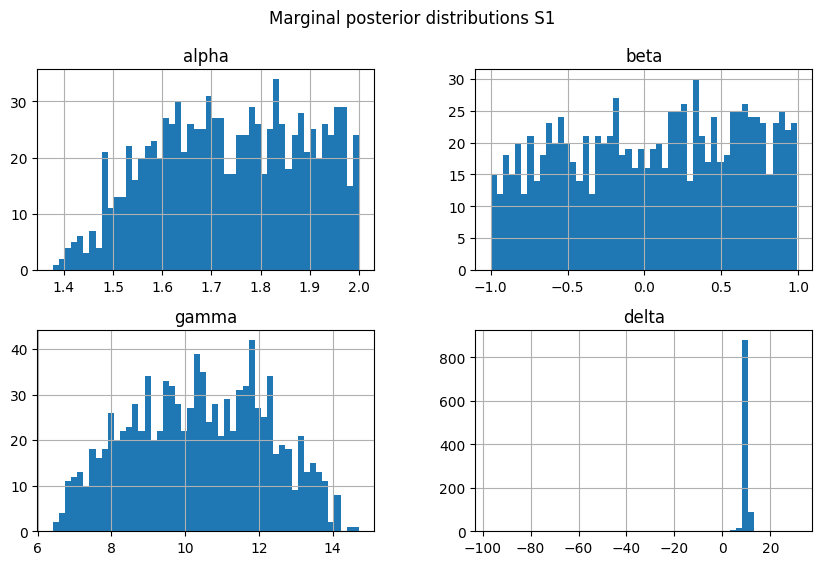

alpha  mean = 1.740,  95% CI = [1.455, 1.986]
beta   mean = 0.056,  95% CI = [-0.924, 0.950]
gamma  mean = 10.379,  95% CI = [7.026, 13.656]
delta  mean = 9.759,  95% CI = [8.123, 11.781]


In [60]:
plot_theta(accepted_thetass1,1)

In [45]:
plot_theta(accepted_thetas2,2)
plot_theta(accepted_thetass3,3)
plot_theta(accepted_thetass4,4)
plot_theta(accepted_thetass5,5)

NameError: name 'accepted_thetas2' is not defined

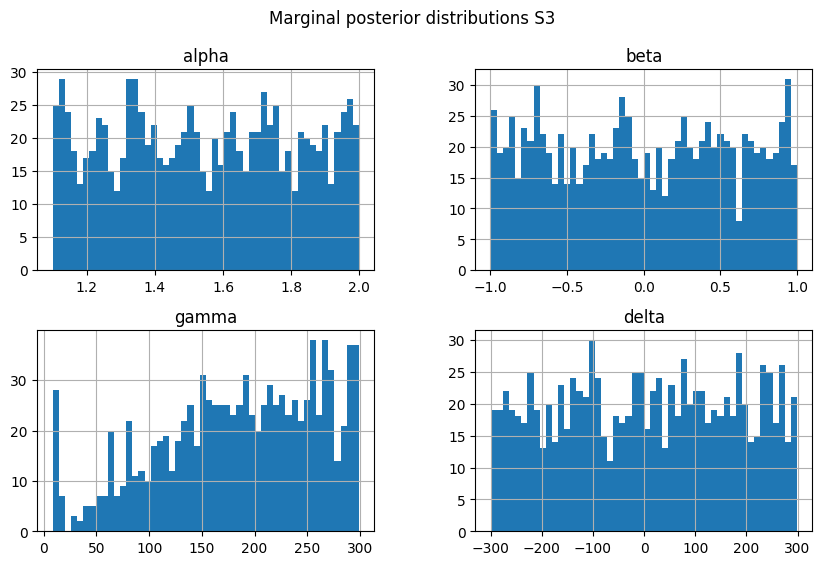

alpha  mean = 1.547,  95% CI = [1.119, 1.977]
beta   mean = -0.002,  95% CI = [-0.957, 0.947]
gamma  mean = 184.981,  95% CI = [13.228, 295.651]
delta  mean = 2.592,  95% CI = [-284.734, 283.215]


In [193]:
plot_theta(accepted_thetass3,3)

The result obtained for each algorithm are then presented

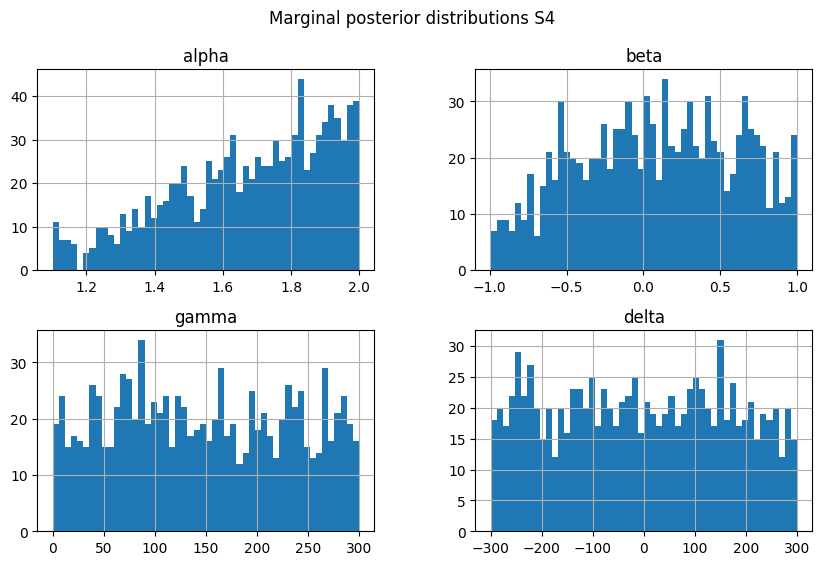

alpha  mean = 1.674,  95% CI = [1.155, 1.986]
beta   mean = 0.082,  95% CI = [-0.870, 0.956]
gamma  mean = 147.877,  95% CI = [8.147, 291.997]
delta  mean = -5.377,  95% CI = [-280.375, 282.740]


In [191]:
plot_theta(accepted_thetass4,4)

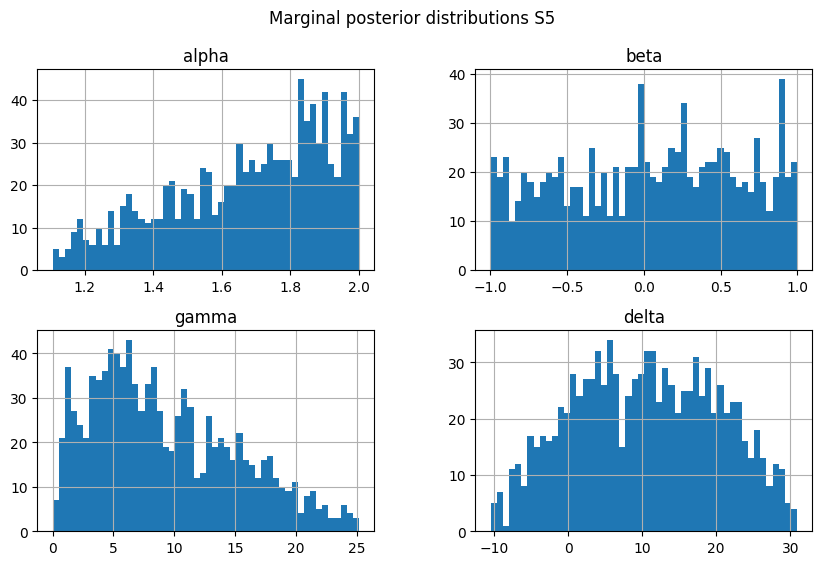

alpha  mean = 1.672,  95% CI = [1.184, 1.991]
beta   mean = 0.045,  95% CI = [-0.951, 0.949]
gamma  mean = 9.302,  95% CI = [0.958, 22.110]
delta  mean = 10.485,  95% CI = [-7.009, 28.198]


In [41]:
plot_theta(accepted_thetass5,5)